## Setup

In [2]:
import os
from dotenv import load_dotenv
from src import util
import gc

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import optuna
import joblib

In [21]:
load_dotenv()

slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V2.parquet")
target_column = "target_class_in_24h"

df_model_input = util.create_df_model_input(slided_df_path, target_column, "xl_", '10min', 'last')

In [4]:
great_filter_training_pool = df_model_input[df_model_input[target_column] > 0].copy()

In [5]:
train_pct = 0.7
val_pct = (1-train_pct)/2
test_pct = (1-train_pct)/2

great_filter_data = util.prepare_data(great_filter_training_pool, target_column, lambda lb: 1 if lb >= 4 else 0, train_pct, val_pct)

## Features Importance

In [6]:
great_filter_initial_model = joblib.load("../../models/great_filter_model_v1.joblib")

In [7]:
feature_names = great_filter_data['x']['train'].columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': great_filter_initial_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

In [8]:
print("--- Tabela de Importância Acumulada ---")
print(importance_df.head(25))

--- Tabela de Importância Acumulada ---
           feature  importance  cumulative_importance
6      xl_mean_12h    0.103888               0.103888
9      xl_mean_24h    0.095141               0.199029
10      xl_std_24h    0.054831               0.253860
3       xl_mean_6h    0.052468               0.306328
11      xl_max_24h    0.052098               0.358427
5        xl_max_6h    0.052045               0.410471
17      xl_max_14D    0.047636               0.458107
14       xl_max_7D    0.044212               0.502319
20      xl_max_30D    0.042671               0.544990
19      xl_std_30D    0.041899               0.586889
16      xl_std_14D    0.041700               0.628589
0       xl_mean_1h    0.041435               0.670023
13       xl_std_7D    0.040112               0.710135
18     xl_mean_30D    0.039691               0.749827
15     xl_mean_14D    0.036357               0.786184
2        xl_max_1h    0.032730               0.818914
12      xl_mean_7D    0.031807            

In [9]:
THRESHOLD = 0.95

features_to_keep = importance_df[importance_df['cumulative_importance'] <= THRESHOLD]['feature'].tolist()

if len(features_to_keep) < 5:
    features_to_keep = importance_df['feature'].head(10).tolist()

print(f"\nNúmero original de features: {len(feature_names)}")
print(f"Número de features após corte de {THRESHOLD*100}%: {len(features_to_keep)}")
print("\nFeatures selecionadas:")
print(features_to_keep)


Número original de features: 27
Número de features após corte de 95.0%: 20

Features selecionadas:
['xl_mean_12h', 'xl_mean_24h', 'xl_std_24h', 'xl_mean_6h', 'xl_max_24h', 'xl_max_6h', 'xl_max_14D', 'xl_max_7D', 'xl_max_30D', 'xl_std_30D', 'xl_std_14D', 'xl_mean_1h', 'xl_std_7D', 'xl_mean_30D', 'xl_mean_14D', 'xl_max_1h', 'xl_mean_7D', 'xl_max_12h', 'xl_std_1h', 'xl_std_12h']


## Training and Parameter Tuning

In [10]:
great_filter_lean_data = {
    'x': {
        'train': great_filter_data['x']['train'][features_to_keep].copy(),
        'val':   great_filter_data['x']['val'][features_to_keep].copy(),
        'test':  great_filter_data['x']['test'][features_to_keep].copy()
    },
    'y': great_filter_data['y']
}

In [12]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,

        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 10.0, 400.0, log=True),

        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model_ = xgb.XGBClassifier(**params)

    model_.fit(
        great_filter_lean_data['x']['train'],
        great_filter_lean_data['y']['train'],
        eval_set=[(great_filter_lean_data['x']['val'], great_filter_lean_data['y']['val'])],
        verbose=False
    )

    y_pred_val = model_.predict(great_filter_lean_data['x']['val'])

    score = f1_score(great_filter_lean_data['y']['val'], y_pred_val, average='macro')

    return score

In [13]:
study = optuna.create_study(direction='maximize')
print("\nIniciando o tuning para o 'Great Filter' (Modelo 2)...")
study.optimize(objective, n_trials=500)

print("\nBusca concluída!")
print(f"Melhor valor (macro f1-score): {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-11-08 17:52:11,992] A new study created in memory with name: no-name-60ac4bf4-9627-4ebc-8062-e67c356709a3



Iniciando o tuning para o 'Great Filter' (Modelo 2)...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [17:52:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-11-08 17:52:19,712] Trial 0 finished with value: 0.6191116744671874 and parameters: {'scale_pos_weight': 235.29790287146434, 'max_depth': 5, 'learning_rate': 0.14898039790199194, 'subsample': 0.8213634533283486, 'colsample_bytree': 0.7189840223854109, 'gamma': 4.342628488096576, 'min_child_weight': 6}. Best is trial 0 with value: 0.6191116744671874.
[I 2025-11-08 17:52:30,039] Trial 1 finished 


Busca concluída!
Melhor valor (macro f1-score): 0.6997
Melhores parâmetros encontrados:
{'scale_pos_weight': 10.676533819560484, 'max_depth': 10, 'learning_rate': 0.016554905640203347, 'subsample': 0.9680672973857727, 'colsample_bytree': 0.6004387229122748, 'gamma': 3.6063310544123186, 'min_child_weight': 1}


In [16]:
great_filter_params = study.best_params

great_filter_params.update({
    'n_estimators': 1000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 1502,
    'n_jobs': -1,
    'early_stopping_rounds': 50
})

In [17]:
great_filter_model = xgb.XGBClassifier(**great_filter_params)

print("\nIniciando o treinamento do 'Great Filter' (Modelo 2)...")
great_filter_model.fit(
    great_filter_lean_data['x']['train'],
    great_filter_lean_data['y']['train'],
    eval_set=[(great_filter_lean_data['x']['val'], great_filter_lean_data['y']['val'])],
    verbose=100
)
print("Treinamento concluído.")


Iniciando o treinamento do 'Great Filter' (Modelo 2)...
[0]	validation_0-logloss:1.26391
[100]	validation_0-logloss:0.39024
[200]	validation_0-logloss:0.27102
[300]	validation_0-logloss:0.24374
[400]	validation_0-logloss:0.22961
[500]	validation_0-logloss:0.21907
[600]	validation_0-logloss:0.21259
[700]	validation_0-logloss:0.20775
[800]	validation_0-logloss:0.20476
[900]	validation_0-logloss:0.20180
[999]	validation_0-logloss:0.20038
Treinamento concluído.


## Results

--- Relatório de Classificação (Conjunto de Teste) ---

              precision    recall  f1-score   support

     ABC (0)       0.77      0.49      0.60     90444
      XM (1)       0.58      0.83      0.68     77293

    accuracy                           0.64    167737
   macro avg       0.67      0.66      0.64    167737
weighted avg       0.68      0.64      0.64    167737


--- Matriz de Confusão ---


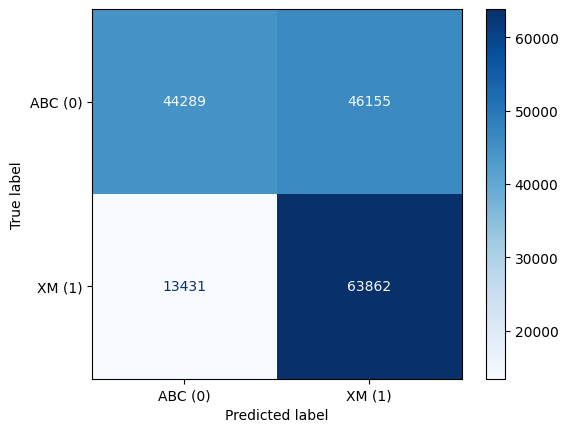

In [18]:
great_filter_y_pred = great_filter_model.predict(great_filter_lean_data['x']['test'])

print("--- Relatório de Classificação (Conjunto de Teste) ---\n")
print(classification_report(great_filter_lean_data['y']['test'], great_filter_y_pred, target_names=['ABC (0)', 'XM (1)']))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(great_filter_lean_data['y']['test'], great_filter_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ABC (0)', 'XM (1)'])
disp.plot(cmap='Blues')
plt.show()

## Evaluating Tradeoff cost

In [25]:
great_filter_lean_data['x'].keys()

dict_keys(['train', 'val', 'test'])

In [26]:
great_filter_y_multiclass = df_model_input[target_column]

val_end = int(len(df_model_input) * (val_pct + train_pct))
great_filter_y_multi_truth = great_filter_y_multiclass.iloc[val_end:]

In [27]:
df_analysis = pd.DataFrame(index=great_filter_lean_data['y']['test'].index)
df_analysis['binary_truth'] = great_filter_lean_data['y']['test']
df_analysis['binary_pred'] = great_filter_y_pred
df_analysis['multiclass_truth'] = great_filter_y_multi_truth

is_false_negative = (df_analysis['binary_truth'] == 1) & (df_analysis['binary_pred'] == 0)
df_false_negatives = df_analysis[is_false_negative]
print(f"Número total de Falsos Negativos encontrados: {len(df_false_negatives)}")

Número total de Falsos Negativos encontrados: 13431


In [28]:
df_false_negatives

,binary_truth,binary_pred,multiclass_truth
ds,,,
2021-10-09 00:20:00,1,0,4
2021-10-09 00:30:00,1,0,4
2021-10-09 00:40:00,1,0,4
2021-10-09 00:50:00,1,0,4
2021-10-09 01:00:00,1,0,4
...,...,...,...
2024-11-25 06:10:00,1,0,4
2024-11-25 06:20:00,1,0,4
2024-11-25 06:30:00,1,0,4


## Exporting Models

In [20]:
model_save_path = r'../../models/great_filter_model_v2.joblib'
joblib.dump(great_filter_model, model_save_path)
print(f"Modelo salvo em {model_save_path}")

Modelo salvo em ../models/great_filter_model_v2.joblib
